In [55]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

This is a neuroscience course, but to understand some of the concepts today lets turn to a classic statistics problem from ecology. This example is relevent to this course insofar as we are on and island, and it never hurts to think about some island ecology!

Charles Darwin  observed that there are many species of finch unique to the Galapogos Islands. Importanlty, these finch appear very similar to those found on the mainland, but with unique specializations specific to their enviornmental niches on the islands. From this, he concluded that the island were likely colonized by birds from the mainland, and over time the bird population on the island adapted to fit the local environment. This was one of the key insigts leading to his theory of evolution.

The finches of the Galapogos have remained an active area of study. From 1973 to 2013, Peter and Rosemary Grand made trips to the island of Daphne Major to collect beak size and shape information about two species of finch, G. Fortis and G. scandens. We will use the distinction between these species to illustrate catigorical regression- a concept that will be useful momentarily when we start thinging about neural encoding. If you are interested, more information on these data are avalible here: https://www.kaggle.com/datasets/crbelhekar619/darwins-finches-evolution-dataset

![Illustration by Rosa Marin Ribas, http://graphictextile.blogspot.com/2017/08/two-finches.html?spref=pi](../resources/geospizas.jpg)

For this example, lets start with data collected in 1975. 

Length and depth units are in mm

In [56]:
finches = pd.read_csv(r'../resources/finch_beaks.csv')
finches.head()

,band,year,species,beaklength,beakdepth
0,2,1975,fortis,9.4,8.0
1,9,1975,fortis,9.2,8.3
2,12,1975,fortis,9.5,7.5
3,15,1975,fortis,9.5,8.0
4,305,1975,fortis,11.5,9.9


In [57]:
finches.tail()

,band,year,species,beaklength,beakdepth
646,21295,2012,scandens,14.2,9.3
647,21297,2012,scandens,13.0,9.8
648,21340,2012,scandens,14.6,8.9
649,21342,2012,scandens,13.1,9.8
650,21347,2012,scandens,15.2,9.1


Lets start by choosing one year's worth of finches to analyse.

In [58]:
finches75 = finches[finches.year==1975]
np.unique(finches.species)

array(['fortis', 'scandens'], dtype=object)

 Step one is ALWAYS to look at your data:

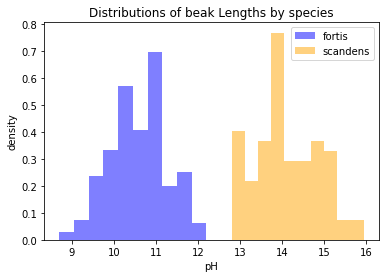

In [59]:
fig,ax = plt.subplots()
ax.hist(finches75[finches75.species=='fortis'].beaklength,density = True,alpha = .5,histtype='bar',label='fortis',color = 'blue');
ax.hist(finches75[finches75.species=='scandens'].beaklength,density = True,alpha = .5,histtype='bar',label='scandens',color = 'orange');
ax.set_ylabel('density')
ax.set_xlabel('pH')
ax.legend()
ax.set_title('Distributions of beak Lengths by species');


Now, lets say that we want to model beak length as a function of finch species. Another way of saying that is "Lets ask if Beak Length is encoded by species information." Perhapse the simplest model we could build would look like this:

$$y = \beta x+C$$

Here, $y$ is our beak length and $X$ is species information. $\beta$ and $C$ are constants.

In this case, however, X is not a continuous variable- really, X has two possible values that are not numeric- fortis or scandens.

One way to handle this would be to construct two models:
$$y = \beta_f X_f+C_f$$
$$y = \beta_s X_s+C_s$$

Mathematically, though, this is a pain - now we need to look up which equation to use every time we want to predict new data. Much easier would be to do things peicewise.

$$y = \begin{cases} 
\beta_f X & is & f  \\
\beta_s X & is & s
\end{cases} + C $$

Notice that, in this formulation, we merged the constants into one value, $C$. $C$ is, effectivly, the offset from zero for any model we fit. In this example, for interpratibility, we are actually going to enforce $C=0$ so that the $\beta$ values we get are easier to understand. We will come back to why merging all the constants makes sense for modeling neurons and tuning curves later later.

Importantly, $X$ here is just the identity of the bird species - it is therefore, always 1! What changes is whether We are operating in the $f$ or $s$ part of the equation. This type of problem is called "One-Hot" encoding, because X encodes what art of the equation we are operating in. Mathematically, we do this by creating a vector for each sample and setting $X_i = 1$ for whichever case is true. 

$$ X_f = [1,0] $$
$$ X_s = [0,1] $$ 

If we have many observations, we can stack each of these X obeservations to form a "Design Matrix." 

We will have a corresponding fitting parameter vector, $$\beta = [\beta_f,\beta_s]$$

Our whole problem can now be written: 
$$y = \beta X$$ 


Convert to one-hot for regression model

In [64]:
its_a_fortis = np.array(finches75.species == 'fortis')
its_a_scandens = np.array(finches75.species=='scandens')
X75 = np.vstack([its_a_fortis,its_a_scandens]).T
X75 = X75.astype(int)

Also get y

In [65]:
y75 = finches75.beaklength

Now that we have $X$ and $y$, we need to solve for $\beta$.  More text is needed here!

$$ \beta = (X^TX)^{-1}X^Ty$$

In [95]:
beta = np.linalg.inv(X75.T@X75) @ X75.T @ y75

print(beta)

[10.56518987 14.12091954]


In [96]:
beta = np.linalg.lstsq(X75,y75,rcond=0)[0]
print(beta)

[10.56518987 14.12091954]


Manually doing linear algebra, however, is not the easiest way to tackle this sort of problem in python. Scikit-learn provides an excelent inerface to tackinging this sort of problem. While it may seem like overkill now, it will be very useful as we address harder problems with more data in the very very near future!

Start by instantiate a fitting object:

In [97]:
LinearModel = lm.LinearRegression(fit_intercept=False) # No C here!

Then use it to fit the model

In [20]:
LinearModel.fit(X75,y75)

LinearRegression(fit_intercept=False)

And look at the results!

In [21]:
LinearModel.coef_

array([10.56518987, 14.12091954])

Could include some prediction here?

In [22]:
prediction75 = LinearModel.predict(X75)
# Would have been better if we held out some data...but maybe more than is needed for this example.

In [23]:
print(prediction75[0])
print(prediction75[-1])

10.56518987341772
14.120919540229886


Plot residuals, that is, distributions of model error.

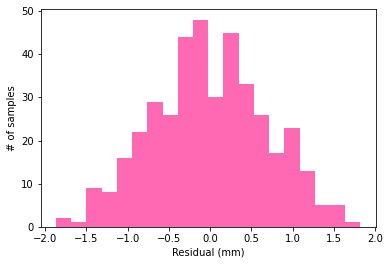

In [25]:
fig,ax = plt.subplots()
ax.hist(y75-prediction75,20,histtype='bar',label='fortis',color = 'hotpink');
ax.set_ylabel('# of samples')
ax.set_xlabel('Residual (mm)');


We really want one number to assess our mode...
Insert math describing variance explained here.

In [26]:
LinearModel.score(X75,y75)

0.8184106108215392

but is this real a fair analysis?

In [42]:
train_X75,test_X75,train_y75,test_y75 = train_test_split(X75,y75,test_size = .2,random_state = 42)
print(X75.shape)
print(train_X75.shape)
print(test_X75.shape)

(403, 2)
(322, 2)
(81, 2)


In [43]:
LinearModel = lm.LinearRegression(fit_intercept=False)
LinearModel.fit(train_X75,train_y75)


LinearRegression(fit_intercept=False)

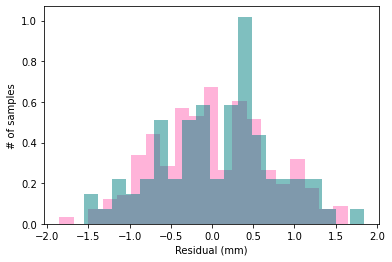

In [44]:
trainprediction75 = LinearModel.predict(train_X75)

testprediction75 = LinearModel.predict(test_X75)
fig,ax = plt.subplots()
ax.hist(train_y75-trainprediction75,20,alpha = .5,density = True,histtype='bar',label='Train Residuals',color = 'hotpink')
ax.hist(test_y75-testprediction75,20,alpha = .5,density = True,histtype='bar',label='Test Residuals',color = 'teal');
ax.set_ylabel('# of samples')
ax.set_xlabel('Residual (mm)');

In [45]:
LinearModel.score(test_X75,test_y75)

0.8159643804487466

Not too much worse!

We can also apply our model to new data.
Lets take data

In [46]:
finches12 = finches[finches.year==2012]
finches12.head()

,band,year,species,beaklength,beakdepth
403,19022,2012,fortis,10.0,8.5
404,19028,2012,fortis,12.5,8.9
405,19032,2012,fortis,9.3,7.5
406,19041,2012,fortis,10.3,9.6
407,19044,2012,fortis,11.0,9.2


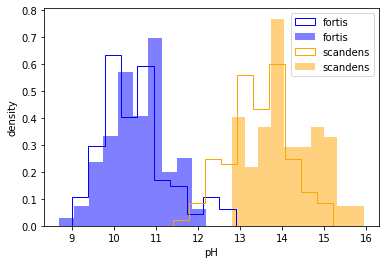

In [47]:
fig,ax = plt.subplots()
ax.hist(finches12[finches12.species=='fortis'].beaklength,density = True,histtype='step',label='fortis',color = 'blue');
ax.hist(finches75[finches75.species=='fortis'].beaklength,density = True,histtype='bar',alpha = .5,label='fortis',color = 'blue');

ax.hist(finches12[finches12.species=='scandens'].beaklength,density = True,histtype='step',label='scandens',color = 'orange');
ax.hist(finches75[finches75.species=='scandens'].beaklength,density = True,histtype='bar',alpha = .5,label='scandens',color = 'orange');

ax.set_ylabel('density')
ax.set_xlabel('pH')
ax.legend()

In [48]:
its_a_fortis = np.array(finches12.species == 'fortis')
its_a_scandens = np.array(finches12.species=='scandens')
X12 = np.vstack([its_a_fortis,its_a_scandens]).T
X12 = X12.astype(int)
y12 = finches12.beaklength

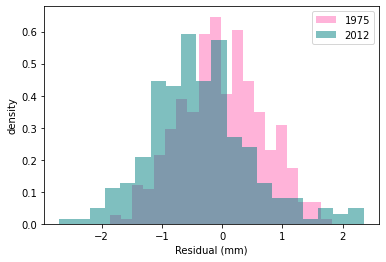

In [53]:
prediction12 = LinearModel.predict(X12)
fig,ax = plt.subplots()
ax.hist(y75-prediction75,20,alpha = .5,color = 'hotpink',label = '1975',density = True)
ax.hist(y12-prediction12,20,alpha = .5,color = 'teal',label = '2012',density=True)
ax.legend()
ax.set_xlabel('Residual (mm)')
ax.set_ylabel('density');

In [54]:
LinearModel.score(X12,y12)

0.696096727713296

This is worse then before!

This is exciting - A model fit on 1975 data does less well at predicting 2012 data than it does on held-out 1975 data. This suggests that between 1975 and 2012, the beak size of the finch species changes. It show that, even in a small timespan, physical feature of the finch species evolve! Amazing things can happen if you spend some time on an island.

After a little evolution for your monday, lets now go tackle a (statisticly) harder problem from neuroscience...